In [19]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import DistilBertTokenizerFast
from transformers import TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm
import spacy

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [ ]:
drake_df = pd.read_csv("Drake.csv")
taylor_df = pd.read_csv("TaylorSwift.csv")
beyonce_df = pd.read_csv("Beyonce.csv", engine='python')
nlp = spacy.load("en_core_web_sm")
# Basic cleaning
def simple_clean(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text
df = pd.concat([
    pd.read_csv("Drake.csv")[['Lyric']].dropna().sample(300, random_state=42).assign(label='Drake'),
    pd.read_csv("TaylorSwift.csv")[['Lyric']].dropna().sample(300, random_state=42).assign(label='Taylor Swift'),
    pd.read_csv("Beyonce.csv", engine='python')[['Lyric']].dropna().sample(300, random_state=42).assign(label='Beyonce')
], ignore_index=True)

def spacy_clean(text):

    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    doc = nlp(text)

    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)


df['clean_lyrics'] = df['Lyric'].apply(spacy_clean)

df['label_encoded'] = LabelEncoder().fit_transform(df['label'])

train_df, test_df = train_test_split(
    df[['clean_lyrics', 'label_encoded']], 
    stratify=df['label_encoded'], 
    test_size=0.2, 
    random_state=42
)

Map: 100%|██████████| 180/180 [00:00<00:00, 4515.56 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.094800
20,1.058000
30,0.959700
40,0.892100
50,0.679200
60,0.715200
70,0.617100
80,0.622700
90,0.515900
100,0.478400



Classification Report:

              precision    recall  f1-score   support

     Beyonce       0.84      0.72      0.77        60
       Drake       0.86      0.92      0.89        60
Taylor Swift       0.80      0.87      0.83        60

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.83      0.83      0.83       180



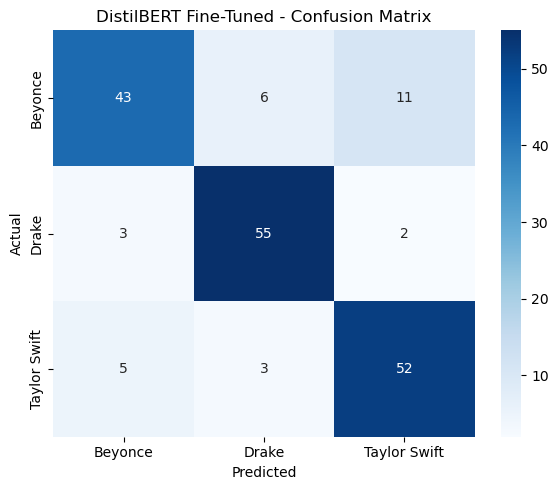

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['clean_lyrics'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df.rename(columns={'label_encoded': 'labels'}))
test_dataset = Dataset.from_pandas(test_df.rename(columns={'label_encoded': 'labels'}))

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=3  # Drake, Taylor Swift, Beyonce
)

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=LabelEncoder().fit(df['label']).classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEncoder().fit(df['label']).classes_, yticklabels=LabelEncoder().fit(df['label']).classes_)
plt.title("DistilBERT Fine-Tuned - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()